# Randomized Image Sampling for Explanations (RISE)

In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
from skimage.transform import resize
from tqdm import tqdm

## Change code below to incorporate your *model* and *input processing*

### Define your model here:

In [2]:
import numpy as np
import cv2
from camera_network_alexnet import alexnet_siamese as camera_network
camera_model = camera_network()

In [3]:
class Model():
    def __init__(self):
        self.model =  torch.load("overfitted_camera_network.pth.tar",map_location=torch.device('cpu'))
        self.input_size = (480, 480)
        self.model.eval()
        
    def run_model(self, uav_input,sat_input):
        return self.model(uav_input.unsqueeze(0),sat_input.unsqueeze(0))

### Load and preprocess image

In [4]:
from keras.preprocessing import image

Using TensorFlow backend.


In [5]:
def load_img(path):
    img = cv2.imread(path)

    return img

---

## RISE

In [6]:
def generate_masks(N, s, p1):
    cell_size = np.ceil(np.array(model.input_size) / s)
    up_size = (s + 1) * cell_size

    grid = np.random.rand(N, s, s) < p1
    grid = grid.astype('float32')

    masks = np.empty((N, *model.input_size))

    for i in tqdm(range(N), desc='Generating masks'):
        # Random shifts
        x = np.random.randint(0, cell_size[0])
        y = np.random.randint(0, cell_size[1])
        # Linear upsampling and cropping
        masks[i, :, :] = resize(grid[i], up_size, order=1, mode='reflect',
                                anti_aliasing=False)[x:x + model.input_size[0], y:y + model.input_size[1]]
    masks = masks.reshape(-1, *model.input_size, 1)
    return masks

In [11]:
from torchvision import datasets, models, transforms
import torch
from PIL import Image
from scipy.special import softmax
to_tensor = transforms.ToTensor()

def explain(model, uav_img, sat_img, masks):
    preds = []

    sat_img = Image.fromarray(sat_img).convert("RGB")
    sat_img = to_tensor(sat_img)

    # Make sure multiplication is being done for correct axes
    for i in tqdm(range(0, N), desc='Explaining'):
        masked = np.zeros_like(uav_img)

        for j in range(len(uav_img.T)):
                masked.T[j] = uav_img.T[j]*masks[i].squeeze()

        masked = to_tensor(masked)

        preds.append(softmax(model.run_model(masked,sat_img)[0].detach().numpy()))

    preds = np.concatenate(preds)
    sal = preds.T.dot(masks.reshape(N, -1)).reshape(-1, *model.input_size)
    sal = sal / N / p1
    return sal,preds

---

## Running explanations

In [8]:
model = Model()

In [9]:
img = load_img("D:\Shetty_data\\train\\atlanta\\uav\\uav0.png")
img2 = load_img("D:\Shetty_data\\train\\atlanta\\sat300\sat0.png")

In [10]:
N = 1000
s = 8
p1 = 0.5
masks = generate_masks(N, s, p1)

Generating masks: 100%|██████████| 1000/1000 [00:16<00:00, 59.69it/s]


In [12]:
sal,preds = explain(model, img,img2, masks)

Explaining: 100%|██████████| 1000/1000 [02:29<00:00,  6.70it/s]


In [13]:
print(preds)

[[0.00932315 0.00072725 0.0007366  ... 0.00069297 0.00059488 0.00093721]
 [0.00900703 0.0007128  0.0007417  ... 0.00070659 0.00056923 0.00092799]
 [0.0089935  0.00073132 0.00074374 ... 0.00070367 0.00058257 0.00095848]
 ...
 [0.00887594 0.00070647 0.00070024 ... 0.00070084 0.00055462 0.00088406]
 [0.00918207 0.00073132 0.0007347  ... 0.00071246 0.00060328 0.0009332 ]
 [0.00893317 0.00070866 0.00071746 ... 0.00069876 0.00054214 0.00092652]]


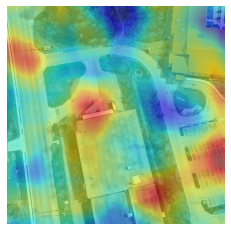

In [42]:
uav_image = Image.fromarray(img).convert("RGB")
uav_image = to_tensor(uav_image)

sat_img = Image.fromarray(img2).convert("RGB")
sat_img = to_tensor(sat_img)

class_idx = np.argmax(model.run_model(uav_image,sat_img)[0].detach().numpy())
#plt.title('Explanaton for `{}`'.format(class_name(class_idx)))
plt.axis('off')
plt.imshow(img)
plt.imshow(sal[class_idx], cmap='jet', alpha=0.5)
# plt.colorbar()
plt.show()